<a href="https://colab.research.google.com/github/AhmadJamal01/Floodead-Inside/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from PIL import Image
import matplotlib.pyplot as plt

## Read the dataset

In [2]:
# !pip install gdal > /dev/null

In [3]:
# import gdown
# gdown.download("https://drive.google.com/uc?id=1och-QmNa3FAiS-wssgzCwISbmpSezIi_", "dataset.zip", quiet=False)
# gdown.extractall("dataset.zip")
# path = 'dataset/'

# # gdown.download("https://drive.google.com/file/d/1YUbTBFrk9QF0ivR5F640G3dhCMC3XQUZ/view?usp=sharing", "dataset.zip", quiet=False, fuzzy=True)

In [4]:
# from google.colab import drive
# import zipfile

# # Mount your Google Drive
# drive.mount('/content/drive')

# # Specify the path to your zip file in Google Drive
# zip_path = '/content/dataset.zip'

# # Extract the zip file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall('/content/')  # Specify the extraction path



In [5]:
# Access the extracted files
path = './dataset/'  # Update with your extraction path
# You can now work with the extracted files in the extracted_files_path directory


## Prepare the data

In [6]:
train_data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
test_data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = torchvision.datasets.ImageFolder(root=path)

# Split the dataset into train and test
TRAIN_SIZE = 0.8
VALIDAtION_SIZE = 0.1

train_size = int(TRAIN_SIZE * len(dataset))
validation_size = int(VALIDAtION_SIZE * len(dataset))
test_size = len(dataset) - (train_size + validation_size)
train, validation, test = torch.utils.data.random_split(dataset, (train_size, validation_size, test_size))

train.dataset.transform = train_data_transforms
validation.dataset.transform = test_data_transforms
test.dataset.transform = test_data_transforms

batch_size = 32
trainLoader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)
validationLoader = torch.utils.data.DataLoader(validation, batch_size=batch_size, shuffle=False, num_workers=2)
testLoader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=2)



## Device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Availabe device for training is: {device}')

Availabe device for training is: cuda


## Model Architecture

### Resenet50

In [8]:
# Define ResNet model 
model = models.resnet50(pretrained=True)

# Modify the last layer to work with two classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Move the model to GPU if possible
# model = model.to(device)

# Define loss function, optimizer, and lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/home/passant-abdelgalil/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/passant-abdelgalil/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Model Enhancement 

### Dropout
Dropout is a regularization technique that can help prevent overfitting by randomly disabling neurons during training. It can be added after fully connected layers to reduce the model's reliance on specific features and encourage better generalization.

In [9]:
# Add Dropout after the last fully connected layer
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)
# use model.classifier for the densenet


## Training

In [10]:
import time
import copy

def train_model(model, trainloader, validationloader, device, criterion, optimizer, step_lr_scheduler, epochs):
    '''
    This code is designed to train a model, track its performance during training, and return the best model along with the loss and accuracy values.
    '''
    try:
        model = model.to(device)

        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        train_acc = []
        train_loss = []
        valid_acc = []
        valid_loss = []

        for epoch in range(epochs):
            print('-' * 80)
            print(f'Epoch {epoch + 1}/{epochs}')

            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()
                    dataloader = trainloader
                    dataset_size = len(trainloader.dataset)
                else:
                    model.eval()
                    dataloader = validationloader
                    dataset_size = len(validationloader.dataset)

                running_loss = 0.0
                running_corrects = 0

                for data in dataloader:
                    # Get the training data items of the current batch
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)

                    with torch.set_grad_enabled(phase == 'train'):
                        # Forward pass
                        outputs = model(inputs)
                        # Predict the current batch
                        _, preds = torch.max(outputs, 1)
                        # Compute loss
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            # Set the gradients of all the parameters of the model to zero
                            optimizer.zero_grad()
                            # Backward propagation to calculate the gradient
                            loss.backward()
                            # Update the NN weights by using the gradient
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    step_lr_scheduler.step()

                epoch_loss = running_loss / dataset_size
                epoch_acc = running_corrects.double() / dataset_size

                if phase == 'valid':
                    valid_acc.append(epoch_acc)
                    valid_loss.append(epoch_loss)
                else:
                    train_acc.append(epoch_acc)
                    train_loss.append(epoch_loss)

                print('{} loss: {:.4f} --------------- {} accuracy: {:.4f}'.format(phase, epoch_loss, phase, epoch_acc))

                # deep copy the model
                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('-' * 80)
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best validation accuracy: {:4f}'.format(best_acc))

        # load best model weights
        print('Loading final model weights...')
        model.load_state_dict(best_model_wts)
        return model, train_loss, train_acc, valid_loss, valid_acc

    except Exception as e:
        print(f"An error occurred during training: {str(e)}")
        return None, [], [], [], []


In [83]:
# model, train_loss, train_acc, valid_loss, valid_acc = train_model(model, trainLoader, validationLoader, device, criterion, optimizer, step_lr_scheduler, epochs=15)

--------------------------------------------------------------------------------
Epoch 1/15
train loss: 0.3153 --------------- train accuracy: 0.8820
valid loss: 0.6740 --------------- valid accuracy: 0.9130
--------------------------------------------------------------------------------
Epoch 2/15
train loss: 0.1946 --------------- train accuracy: 0.9281
valid loss: 1.7010 --------------- valid accuracy: 0.7826
--------------------------------------------------------------------------------
Epoch 3/15
train loss: 0.1628 --------------- train accuracy: 0.9471
valid loss: 0.1848 --------------- valid accuracy: 0.9565
--------------------------------------------------------------------------------
Epoch 4/15
train loss: 0.1508 --------------- train accuracy: 0.9552
valid loss: 0.2880 --------------- valid accuracy: 0.8913
--------------------------------------------------------------------------------
Epoch 5/15
train loss: 0.1309 --------------- train accuracy: 0.9593
valid loss: 0.2121

## Evaluation

In [11]:
# model

### Loading the model

In [12]:
model.load_state_dict(torch.load("resnet50.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
import cv2

finalconv_name = 'layer4'
features_blob = []
def hook_feature(module, input, output):
  features_blob.append(output.data.cpu().numpy())

model._modules.get(finalconv_name).register_forward_hook(hook_feature)
# get the softmax weight
params = list(model.parameters())
weight_toSoftmax = np.squeeze(params[-4].data.cpu().numpy())
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())


In [14]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        weights = weight_toSoftmax.T.dot(weight_softmax[idx].reshape((-1,1)))
        cam = weights.T.dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam_img = np.interp(cam, (cam.min(), cam.max()), (0, 255)).astype(np.uint8)
        # cam = cam - np.min(cam)
        # cam_img = cam / np.max(cam)
        # cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [15]:
def predict(model, dataloader, device):
    all_CAMs = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        j = 0
        for inputs, labels in dataloader:
            inputs, labels = inputs, labels
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            predicted = predicted.cpu().numpy()

            for i, blob in enumerate(predicted):            
              CAM = returnCAM(features_blob[j][i], weight_softmax, [predicted[i]])
              all_CAMs += CAM
            
            y_pred.extend(predicted)
            y_true.extend(labels.cpu().numpy())
            j += 1
            
    return np.asarray(y_pred), np.asarray(y_true), all_CAMs

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score

# Test the model on the test dataset
y_pred, y_true, CAMs = predict(model, testLoader, device)
        
# Evalaution
# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('F1 Score: {:.2f}'.format(f1))

# Show the whole report
classification_report = classification_report(y_true, y_pred)
print(classification_report)


Accuracy: 97.85%
F1 Score: 0.98
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        44
           1       0.96      1.00      0.98        49

    accuracy                           0.98        93
   macro avg       0.98      0.98      0.98        93
weighted avg       0.98      0.98      0.98        93



## Saving the model

In [17]:
# save model
# torch.save(model.state_dict(), 'resnet50_2.pth')

In [27]:
def blend_cam(cam, img):

    heatmap = cv2.applyColorMap(np.asarray(cam).astype(np.uint8), cv2.COLORMAP_JET)
    img =  np.moveaxis(img, 0, -1)
    interp_img = np.interp(img, (img.min(), img.max()), (0, 255)).astype(np.uint8)
    # img = np.moveaxis(img, 0, -1)*255
    original = Image.fromarray(interp_img.astype(np.uint8))
    clustered = Image.fromarray(heatmap)

    original_rgba = original.convert("RGBA")
    clustered_rgba = clustered.convert("RGBA")

    blended = Image.blend(original_rgba, clustered_rgba, alpha=.4)

    return blended, clustered

In [28]:
images = []
for imgs, _ in testLoader:
  images += imgs  
masks = []
original_images = []
non_flooded = []
clustereds = []
non_flooded_masks = []
for pred_label, cam, i in zip(y_pred, CAMs, range(len(y_pred))):
  img = images[i].numpy()
  blended, clustered =  blend_cam(cam, img)
  if pred_label == 0: # if classified flooded
    masks.append(blended)
    clustereds.append(clustered)
    original_images.append(img)
  else:
    non_flooded.append(img)
    non_flooded_masks.append(blended)


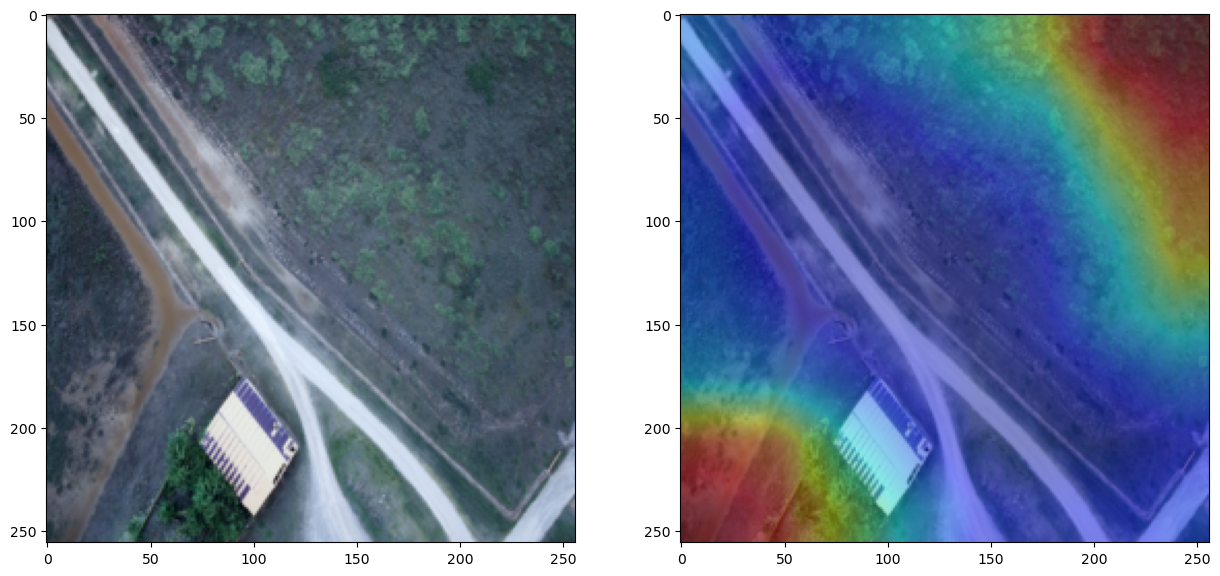

In [29]:
selected = 0

img =  np.moveaxis(non_flooded[selected], 0, -1)
interp_img = np.interp(img, (img.min(), img.max()), (0, 255)).astype(np.uint8)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.imshow(interp_img)
ax2.imshow(non_flooded_masks[selected])
plt.show()

In [94]:
selected = 0

img =  np.moveaxis(original_images[selected], 0, -1)
interp_img = np.interp(img, (img.min(), img.max()), (0, 255)).astype(np.uint8)


In [95]:
img = np.asarray(clustereds[selected])
criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 1.0)
_, kClustered, centers  = cv2.kmeans(img.reshape(-1, 3).astype(np.float32), 2, None, criteria, 300, cv2.KMEANS_PP_CENTERS)

# kClustered = KMeans(n_clusters=2, random_state=42, ).fit_predict(img.reshape(-1, 3))

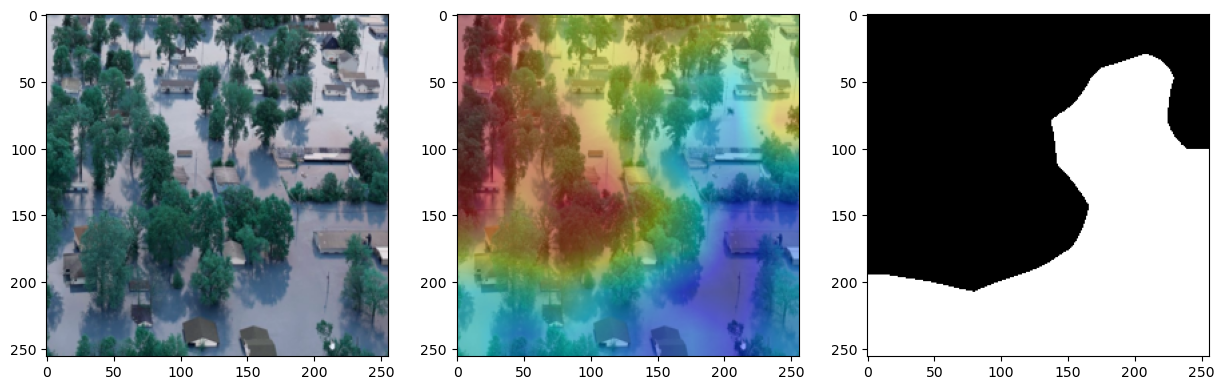

In [96]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))
ax1.imshow(interp_img)
ax2.imshow(masks[selected])
ax3.imshow(kClustered.reshape(img.shape[:2]), cmap='gray')
plt.show()